#Урок 3. Связь бизнес-показателей и DS-метрик

__1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта__




In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import seaborn as sns
import itertools
import matplotlib.pyplot as plt

In [2]:
!wget 'https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G' -O train_case2.csv

--2022-03-15 10:16:21--  https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Resolving drive.google.com (drive.google.com)... 108.177.127.102, 108.177.127.101, 108.177.127.100, ...
Connecting to drive.google.com (drive.google.com)|108.177.127.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gipfif07fgu3ikkbahhu9toarsmekbip/1647339375000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download [following]
--2022-03-15 10:16:22--  https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gipfif07fgu3ikkbahhu9toarsmekbip/1647339375000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download
Resolving doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleusercontent.com)... 108.177.119.132, 2a00:1450:4013:c00::84
Connecting to doc-00-c0-docs.googleusercontent.com (doc-00-c0

In [3]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [4]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), 
                                                    df['cardio'], random_state=0)

In [5]:
# К полям: gender, cholesterol применим OHE-кодирование; 
# age, height, weight, ap_hi, ap_lo - standardScaler;
# gluc, smoke, alco, active - оставим пока как есть.
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))


In [6]:
# Теперь объединим все наши трансформеры с помощью FeatureUnion
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [7]:
# Добавим классификатор и запустим кросс-валидацию
classifier = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=42)),
])


# запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7864573689384385+-0.004422021036885763


In [8]:
# Посчитаем precision/recall/f_score
b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3869370891147379, F-Score=0.730, Precision=0.647, Recall=0.838


In [9]:
precision_1 = precision[ix]
recall_1 = recall[ix]
fscore_1 = fscore[ix]
thresholds_1 = thresholds[ix]

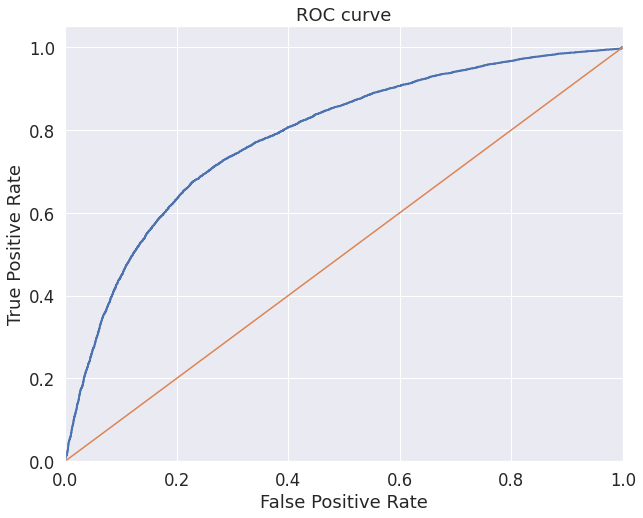

In [10]:
# Нарисуем roc auc кривую
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [11]:
# Посчитаем roc_auc
from sklearn.metrics import roc_auc_score

roc_train = roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1])

roc_test = roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])

print(f"roc auc score_train: {roc_train}")

print(f"roc auc score_test: {roc_test}")

roc auc score_train: 0.7870081561637485
roc auc score_test: 0.7840347790421852


In [12]:
roc_train_1 = roc_train
roc_test_1 = roc_test

In [13]:
# Функция построения матрицы ошибок
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


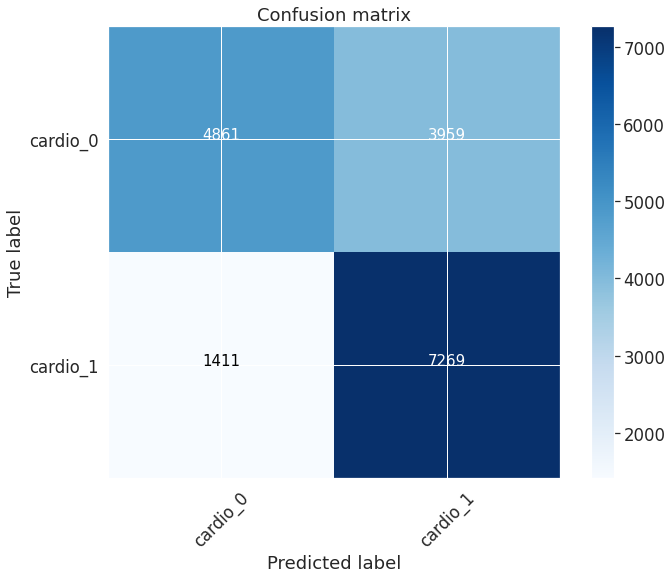

In [14]:
# Посмотрим на матрицу ошибок
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [15]:
# Посчитаем FPR, TPR
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

In [16]:
# Метрика по деньгам
def business_threshold_calibrate(y_test, y_score, thresholds,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    business_threshold = 0
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1_000_000_000 

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_1 = (TP + FN) * rubl_late_treatment
        rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
        
        r_test_all_r_ML = rubl_test_all - rubl_ML 
        
        if rubl_ML < rubl_ML_:            
            business_threshold = opt_buisness_tr
            
            rubl_ML_ = rubl_ML
            
        rs.append(rubl_ML)   
            
    
    print('расходы, если не делать тест и ждать симптомов:', rubl_1)
    print('расходы, если делать тест всем и лечить группу больных:', rubl_test_all)
    print('расходы, если использовать МЛ:', rubl_ML_)

    print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML_)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML_)
    
    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold, rubl_1, rubl_test_all, rubl_ML_

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 152712400
Расходы "решение не делать тесты - расходы с МL:" 20887600
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1987600


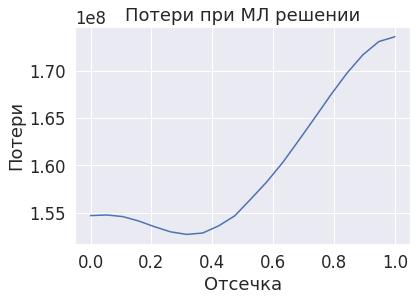

уровень порога по бизнес метрике 0.3157894736842105
уровень порога по f1 метрике 0.3869370891147379


In [17]:
busines_tr_1, rubl_1_1, rubl_test_all_1, rubl_ML_1 = business_threshold_calibrate(y_test, y_score, 
                                                   thresholds[ix],
                                                   rubl_test=1400, 
                                                   rubl_early_treatment=15000, 
                                                   rubl_late_treatment=20000)
rubl_1_ML_1 = rubl_1_1 - rubl_ML_1
rubl_1_test_all_1 = rubl_1_1 - rubl_test_all_1
rubl_test_all_ML_1 = rubl_test_all_1 - rubl_ML_1

print('уровень порога по бизнес метрике', busines_tr_1)
print('уровень порога по f1 метрике', thresholds_1)

Дерево решений:

In [18]:
# Добавим классификатор и запустим кросс-валидацию
classifier = Pipeline([
    ('features', feats),
    ('classifier', tree.DecisionTreeClassifier(random_state=42)),
])


# запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.6346727181484935+-0.005351116040921894


In [19]:
# Посчитаем precision/recall/f_score
b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.0, F-Score=0.663, Precision=0.496, Recall=1.000


In [20]:
precision_2 = precision[ix]
recall_2 = recall[ix]
fscore_2 = fscore[ix]
thresholds_2 = thresholds[ix]

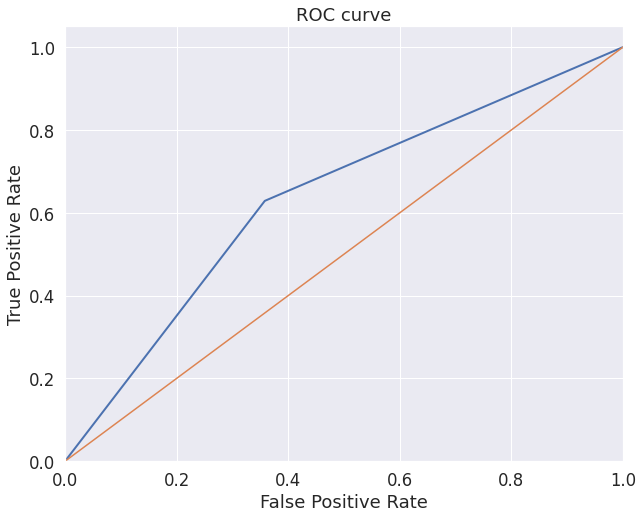

In [21]:
# Нарисуем roc auc кривую
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [22]:
# Посчитаем roc_auc
from sklearn.metrics import roc_auc_score

roc_train = roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1])

roc_test = roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])

print(f"roc auc score_train: {roc_train}")

print(f"roc auc score_test: {roc_test}")

roc auc score_train: 0.9999999121992406
roc auc score_test: 0.6353249905953164


In [23]:
roc_train_2 = roc_train
roc_test_2 = roc_test

Confusion matrix, without normalization
[[5656 3164]
 [3219 5461]]


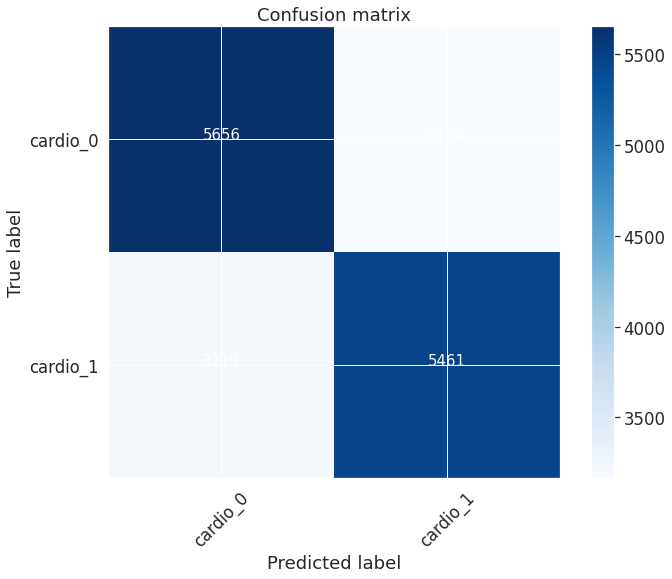

In [24]:
# Посмотрим на матрицу ошибок
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [25]:
# Посчитаем FPR, TPR
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.629147465437788, 0.35873015873015873, 0.6412698412698413)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 158370000
Расходы "решение не делать тесты - расходы с МL:" 15230000
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": -3670000


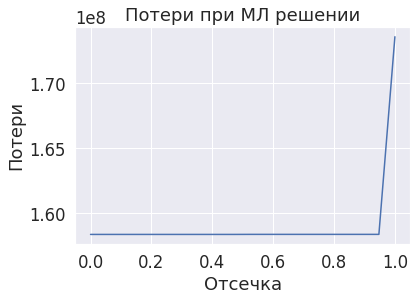

уровень порога по бизнес метрике 0.0
уровень порога по f1 метрике 0.0


In [26]:
# Метрика по деньгам
busines_tr_2, rubl_1_2, rubl_test_all_2, rubl_ML_2 = business_threshold_calibrate(y_test, y_score, 
                                                   thresholds[ix],
                                                   rubl_test=1400, 
                                                   rubl_early_treatment=15000, 
                                                   rubl_late_treatment=20000)
rubl_1_ML_2 = rubl_1_2 - rubl_ML_2
rubl_1_test_all_2 = rubl_1_2 - rubl_test_all_2
rubl_test_all_ML_2 = rubl_test_all_2 - rubl_ML_2

print('уровень порога по бизнес метрике', busines_tr_2)
print('уровень порога по f1 метрике', thresholds_2)

Случайный лес:

In [27]:
# Добавим классификатор и запустим кросс-валидацию
classifier = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42)),
])


# запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7743796633622809+-0.003611330100912611


In [28]:
# Посчитаем precision/recall/f_score
b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.35, F-Score=0.719, Precision=0.643, Recall=0.816


In [29]:
precision_3 = precision[ix]
recall_3 = recall[ix]
fscore_3 = fscore[ix]
thresholds_3 = thresholds[ix]

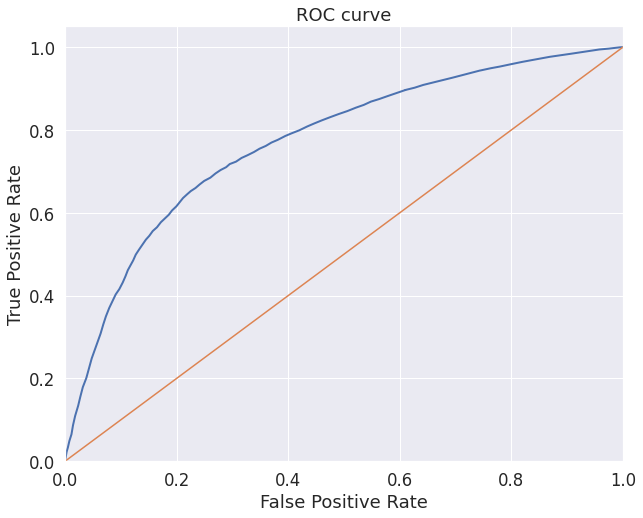

In [30]:
# Нарисуем roc auc кривую
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [31]:
# Посчитаем roc_auc
from sklearn.metrics import roc_auc_score

roc_train = roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1])

roc_test = roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])

print(f"roc auc score_train: {roc_train}")

print(f"roc auc score_test: {roc_test}")

roc auc score_train: 0.9999996132412827
roc auc score_test: 0.7710366181802983


In [32]:
roc_train_3 = roc_train
roc_test_3 = roc_test

Confusion matrix, without normalization
[[4991 3829]
 [1663 7017]]


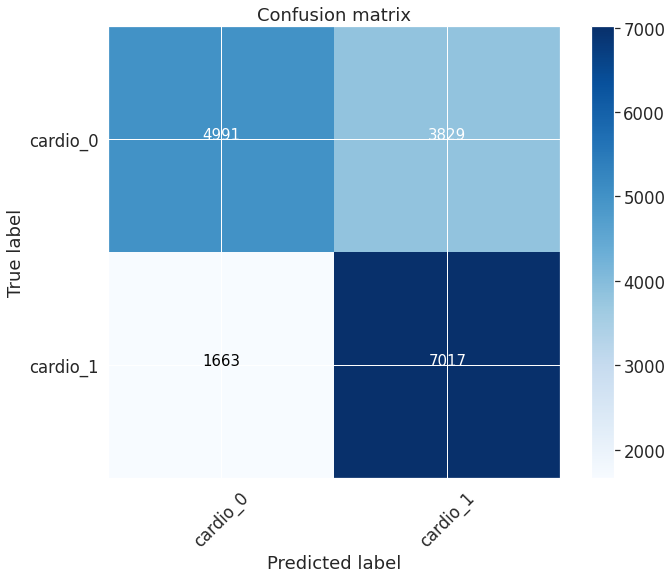

In [33]:
# Посмотрим на матрицу ошибок
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [34]:
# Посчитаем FPR, TPR
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.8084101382488479, 0.43412698412698414, 0.5658730158730159)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 153132800
Расходы "решение не делать тесты - расходы с МL:" 20467200
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1567200


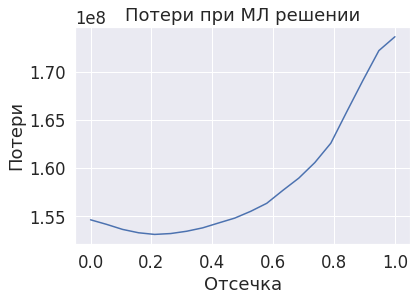

уровень порога по бизнес метрике 0.21052631578947367
уровень порога по f1 метрике 0.35


In [35]:
# Метрика по деньгам
busines_tr_3, rubl_1_3, rubl_test_all_3, rubl_ML_3 = business_threshold_calibrate(y_test, y_score, 
                                                   thresholds[ix],
                                                   rubl_test=1400, 
                                                   rubl_early_treatment=15000, 
                                                   rubl_late_treatment=20000)
rubl_1_ML_3 = rubl_1_3 - rubl_ML_3
rubl_1_test_all_3 = rubl_1_3 - rubl_test_all_3
rubl_test_all_ML_3 = rubl_test_all_3 - rubl_ML_3

print('уровень порога по бизнес метрике', busines_tr_3)
print('уровень порога по f1 метрике', thresholds_3)

Градиентный бустинг:

In [36]:
# Добавим классификатор и запустим кросс-валидацию
classifier = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                   random_state=42)),
])


# запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7895530140107562+-0.0035326955035437993


In [37]:
# Посчитаем precision/recall/f_score
b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3381157470561067, F-Score=0.732, Precision=0.652, Recall=0.833


In [38]:
precision_4 = precision[ix]
recall_4 = recall[ix]
fscore_4 = fscore[ix]
thresholds_4 = thresholds[ix]

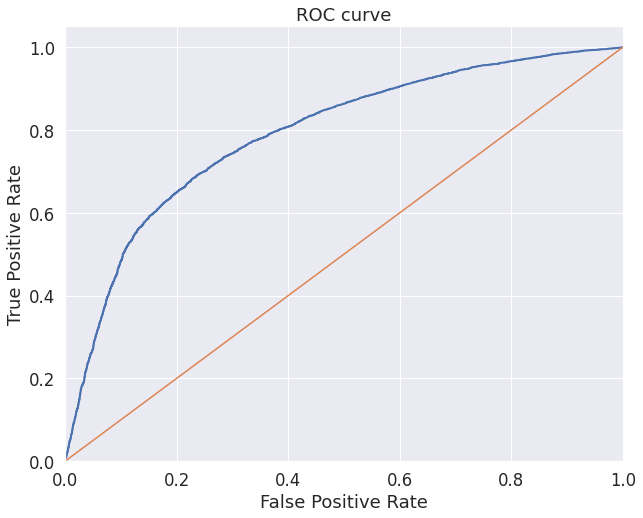

In [39]:
# Нарисуем roc auc кривую
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [40]:
# Посчитаем roc_auc
from sklearn.metrics import roc_auc_score

roc_train = roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1])

roc_test = roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])

print(f"roc auc score_train: {roc_train}")

print(f"roc auc score_test: {roc_test}")

roc auc score_train: 0.8226777364161382
roc auc score_test: 0.7895589268733607


In [41]:
roc_train_4 = roc_train
roc_test_4 = roc_test

Confusion matrix, without normalization
[[4968 3852]
 [1452 7228]]


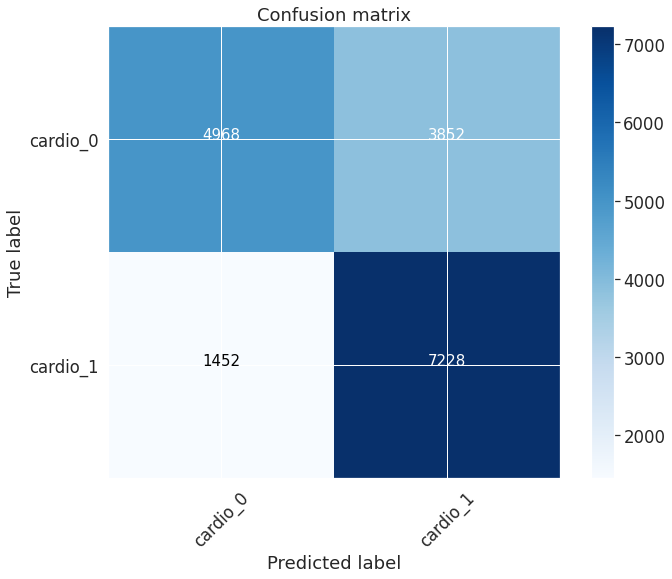

In [42]:
# Посмотрим на матрицу ошибок
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [43]:
# Посчитаем FPR, TPR
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.8327188940092166, 0.43673469387755104, 0.563265306122449)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 152724400
Расходы "решение не делать тесты - расходы с МL:" 20875600
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1975600


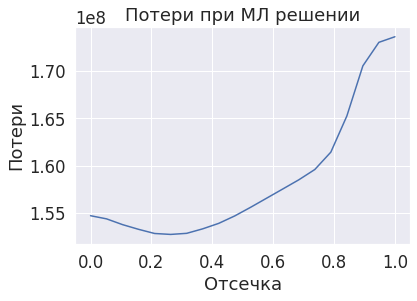

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.3381157470561067


In [44]:
# Метрика по деньгам
busines_tr_4, rubl_1_4, rubl_test_all_4, rubl_ML_4 = business_threshold_calibrate(y_test, y_score, 
                                                   thresholds[ix],
                                                   rubl_test=1400, 
                                                   rubl_early_treatment=15000, 
                                                   rubl_late_treatment=20000)
rubl_1_ML_4 = rubl_1_4 - rubl_ML_4
rubl_1_test_all_4 = rubl_1_4 - rubl_test_all_4
rubl_test_all_ML_4 = rubl_test_all_4 - rubl_ML_4

print('уровень порога по бизнес метрике', busines_tr_4)
print('уровень порога по f1 метрике', thresholds_4)

__2. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)__

In [45]:
roc_tr = [roc_train_1, roc_train_2, roc_train_3, roc_train_4]
roc_tst = [roc_test_1, roc_test_2, roc_test_3, roc_test_4]
prec = [precision_1, precision_2, precision_3, precision_4]
rec = [recall_1, recall_2, recall_3, recall_4]
f_s = [fscore_1, fscore_2, fscore_3, fscore_4]
score_list = [roc_tr, roc_tst, prec, rec, f_s]

final_tab = pd.DataFrame(score_list, index=['roc_auc_train', 'roc_auc_test', 'precision', 'recall', 'f_score'], 
                         columns=['LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting'])
final_tab

,LogisticRegression,DecisionTree,RandomForest,GradientBoosting
roc_auc_train,0.787008,1.000000,1.000000,0.822678
roc_auc_test,0.784035,0.635325,0.771037,0.789559
precision,0.647431,0.496000,0.642669,0.652378
recall,0.837558,1.000000,0.815553,0.832834
f_score,0.730323,0.663102,0.718863,0.731643


__3. Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока
    - стоимость лечения 15000р, если сделали тест и начали лечить вовремя
    - стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
    - стоимость теста 1400р__

In [46]:
cost_without_test = [rubl_1_1, rubl_1_2, rubl_1_3, rubl_1_4]
cost_test_all = [rubl_test_all_1, rubl_test_all_2, rubl_test_all_3, rubl_test_all_4]
cost_ML = [rubl_ML_1, rubl_ML_2, rubl_ML_3, rubl_ML_4]
cost_wt_cost_ML = [rubl_1_ML_1, rubl_1_ML_2, rubl_1_ML_3, rubl_1_ML_4]
cost_wt_cost_ta = [rubl_1_test_all_1, rubl_1_test_all_2, rubl_1_test_all_3, rubl_1_test_all_4]
cost_ta_cost_ML = [rubl_test_all_ML_1, rubl_test_all_ML_2, rubl_test_all_ML_3, rubl_test_all_ML_4]
cost_list = [cost_without_test, cost_test_all, cost_ML, cost_wt_cost_ML, cost_wt_cost_ta, cost_ta_cost_ML]

final_tab = pd.DataFrame(cost_list, index=['cost_without_test', 'cost_test_all', 'cost_ML', 'cost_without_test - cost_ML',
                                           'cost_without_test - cost_test_all', 'cost_test_all - cost_ML'], 
                         columns=['LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting'])
final_tab

,LogisticRegression,DecisionTree,RandomForest,GradientBoosting
cost_without_test,173600000,173600000,173600000,173600000
cost_test_all,154700000,154700000,154700000,154700000
cost_ML,152712400,158370000,153132800,152724400
cost_without_test - cost_ML,20887600,15230000,20467200,20875600
cost_without_test - cost_test_all,18900000,18900000,18900000,18900000
cost_test_all - cost_ML,1987600,-3670000,1567200,1975600


__4. Сделать выводы о том, какая модель справилась с задачей лучше других__

__Ответ:__

Лучше всех , судя по бизнес-метрикам, с задачей справилась модель "LogisticRegression", след в след за ней с минимальным отставанием следует "GradientBoosting".

__5. *Найти порог классификации по деньгам для лучшей модели
    - Стоимость лечения 15000р, если сделали тест и начали лечить вовремя
    - Стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
    - Стоимость теста 1400р__

In [47]:
threshold_f1 = [thresholds_1, thresholds_2, thresholds_3, thresholds_4]
business_tr = [busines_tr_1, busines_tr_2, busines_tr_3, busines_tr_4]
thresholds_list = [threshold_f1, business_tr]

final_tab = pd.DataFrame(thresholds_list, index=['threshold_f1', 'business_threshold'], 
                         columns=['LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting'])
final_tab

,LogisticRegression,DecisionTree,RandomForest,GradientBoosting
threshold_f1,0.386937,0.0,0.350000,0.338116
business_threshold,0.315789,0.0,0.210526,0.263158


Порог классификации по деньгам для лучшей модели, т.е. для "LogisticRegression" составляет 0,315789.